# Credit Card Fraud

This dataset consists of credit card transactions in the western United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud.

Import packages

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Data Dictionary

| transdatetrans_time | Transaction DateTime                        |
|---------------------|---------------------------------------------|
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| lat                 | Latitude Location of Purchase               |
| long                | Longitude Location of Purchase              |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

## Objective

A new credit card company has just entered the market in the western United States. The company is promoting itself as one of the safest credit cards to use. They have hired you as their data scientist in charge of identifying instances of fraud. The executive who hired you has have provided you with data on credit card transactions, including whether or not each transaction was fraudulent.

The executive wants to know how accurately you can predict fraud using this data. She has stressed that the model should err on the side of caution: it is not a big problem to flag transactions as fraudulent when they aren't just to be safe. In your report, you will need to describe how well your model functions and how it adheres to these criteria.

## Exploratory data analysis

First, i will check about the dataset in its entirety.


In [2]:
ccf = pd.read_csv('credit_card_fraud.csv') #load data

In [3]:
ccf.head(100) 

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0
1,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0
2,2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.657520,-122.230347,0
3,2019-01-01 00:09:03,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,32.863258,-106.520205,0
4,2019-01-01 00:21:32,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,43.753735,-111.454923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2019-01-01 06:20:49,Hudson-Ratke,grocery_pos,199.55,Littleton,CO,39.5994,-105.0044,320420,Water engineer,1975-07-31,a5c13edd756f36c026630d13672974bd,38.619691,-105.498059,0
96,2019-01-01 06:24:47,Harber Inc,gas_transport,94.48,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,c9235f76ecb45e67372d79ecac2ffb37,49.513555,-117.819653,0
97,2019-01-01 06:25:07,Berge LLC,gas_transport,79.39,Mesa,ID,44.6255,-116.4493,129,Cartographer,1965-12-15,606b05a976ee2bca7323d6afc85e63ce,43.673602,-116.406060,0
98,2019-01-01 06:25:40,Pagac LLC,shopping_pos,5.05,Powell Butte,OR,44.2415,-121.0113,2016,Local government officer,1953-12-25,d44f496e9daab912914ac9513b038df2,44.245679,-121.333658,0


In [4]:
print(ccf.dtypes) #all column types seem ok.
ccf.isna().sum() # no missing values.
print(ccf.describe())
print(ccf.info())
sns.set_style("ticks") 
sns.set_palette("pastel")  

trans_date_trans_time     object
merchant                  object
category                  object
amt                      float64
city                      object
state                     object
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object
                 amt            lat  ...     merch_long       is_fraud
count  339607.000000  339607.000000  ...  339607.000000  339607.000000
mean       70.577984      39.718991  ...    -110.622383       0.005247
std       161.675242       5.094961  ...      12.663998       0.072248
min         1.000000      20.027100  ...    -166.671575       0.000000
25%         9.600000      36.715400  ...    -119.823755       0.000000
50%        46.460000      39.617100  ...    -111.036443       0.0

In [5]:
#subset if it is a fraudulent transaction
ccf_fraud = ccf[ccf['is_fraud']==1]

In [6]:
category_counts = ccf['category'].value_counts()
fraud_category_counts = ccf_fraud['category'].value_counts()

# Get the top 5 most fraudulent transactions
top_5_fraudulent = fraud_category_counts.head(5)

# Convert the list of category names to a comma-separated string
fraudulent_str = ', '.join(top_5_fraudulent.index)

print('The 5 most fraudulent transactions are: ' + fraudulent_str)
frac_coef = fraud_category_counts / category_counts
frac_coef_df = pd.DataFrame({'category': frac_coef.index, 'count': frac_coef.values})
frac_coef_df = frac_coef_df.sort_values(ascending=False,by='count').reset_index().drop('index',axis=1)
frac_coef_df
#if we do a coefficient of the % of transactions compared to how many there were in total numbers change a little but not much


The 5 most fraudulent transactions are: grocery_pos, shopping_net, misc_net, shopping_pos, gas_transport


,category,count
0,shopping_net,0.014443
1,grocery_pos,0.013229
2,misc_net,0.012842
3,shopping_pos,0.006166
4,gas_transport,0.004360
5,travel,0.003197
6,misc_pos,0.003096
7,grocery_net,0.002378
8,entertainment,0.002271
9,personal_care,0.002254


Next, we will analyze the time of day in which a fraudulent transaction is commited.

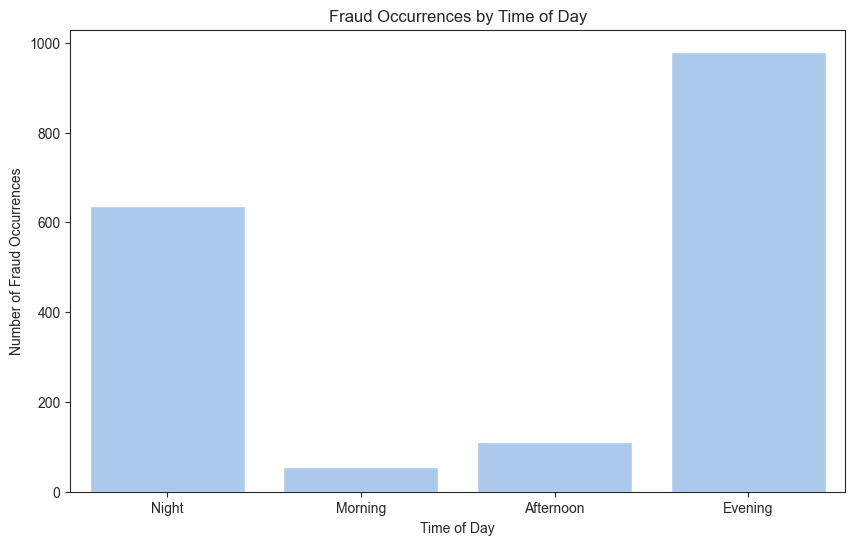

In [7]:
ccf['trans_date_trans_time'] = pd.to_datetime(ccf['trans_date_trans_time'])

def categorize_time_of_day(timestamp):
    hour = timestamp.hour
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply the function to create a new 'time_of_day' column
ccf['time_of_day'] = ccf['trans_date_trans_time'].apply(categorize_time_of_day)
ccf_fraud = ccf[ccf['is_fraud'] == 1]

# Order of time_of_day categories
time_of_day_order = ['Night', 'Morning', 'Afternoon', 'Evening']

# Group by 'time_of_day' and count occurrences
fraud_counts = ccf_fraud['time_of_day'].value_counts().reindex(time_of_day_order)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, order=time_of_day_order)
plt.title('Fraud Occurrences by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Fraud Occurrences')
plt.show()


The analysis reveals a distinctive pattern in credit card fraud occurrences, with a notable concentration during night and evening hours, spanning from 6 pm to 6 am. This temporal trend underscores a heightened susceptibility to fraudulent activities during the later hours of the day, warranting careful attention and targeted preventative measures during this time window.

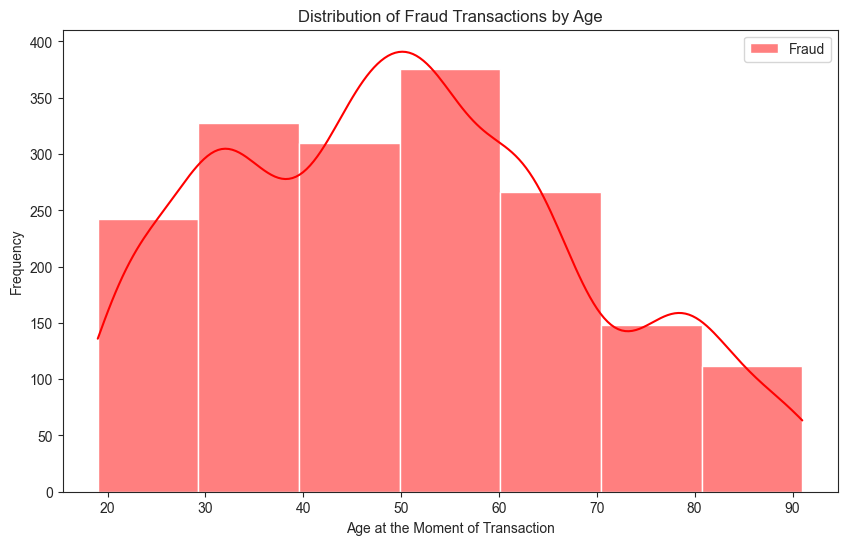

In [8]:
ccf_fraud['dob'] = pd.to_datetime(ccf_fraud['dob'])
ccf_fraud['age_at_moment'] = (ccf_fraud['trans_date_trans_time'] - 
ccf_fraud['dob']).astype('<m8[Y]')

# Assuming ccf_fraud is your DataFrame with transaction data and 'age_at_moment' and 'is_fraud' columns

# Plotting the distribution of age for fraud and non-fraud transactions
plt.figure(figsize=(10, 6))
sns.histplot(ccf_fraud[ccf_fraud['is_fraud'] == 1]['age_at_moment'], color='red', label='Fraud', kde=True,bins=7)
sns.histplot(ccf_fraud[ccf_fraud['is_fraud'] == 0]['age_at_moment'], color='blue', label='Non-Fraud', kde=True,bins=7)

# Adding labels and title
plt.xlabel('Age at the Moment of Transaction')
plt.ylabel('Frequency')
plt.title('Distribution of Fraud Transactions by Age')

# Adding a legend
plt.legend()

# Show the plot
plt.show()

#sns.barplot(x='age_at_moment',y='index',data=age_count)

Surprisingly, the demographic segments most significantly impacted by the phenomenon fall within the age brackets of 30 to 40 and 50 to 60 years. Nonetheless, it's noteworthy that the observed distinctions across various age groups are not particularly pronounced, indicating a relatively consistent pattern of impact across the demographic spectrum.

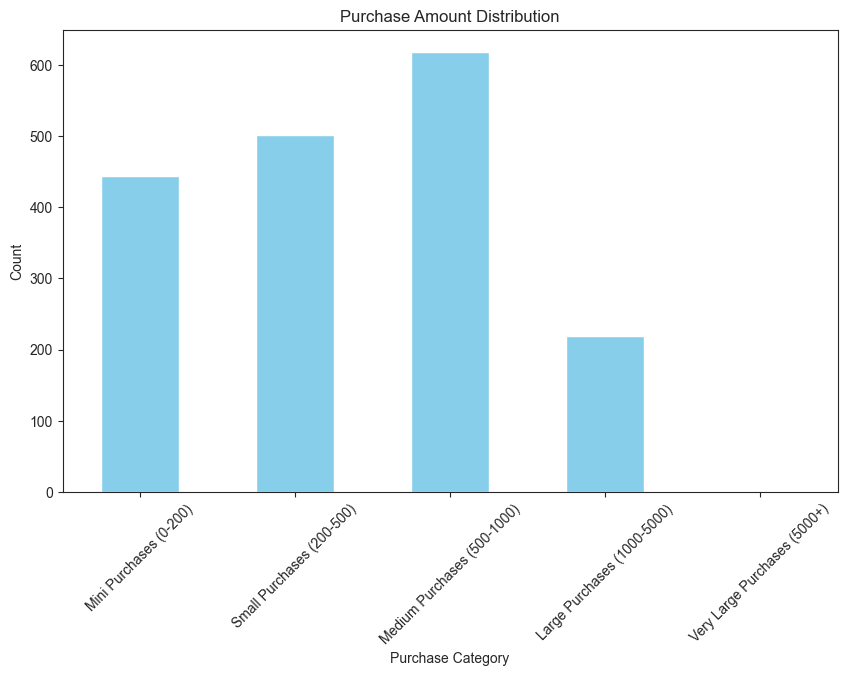

In [9]:
# Define the bins for the histogram
bins1 = [0,200,500,1000, 5000, float('inf')]

# Define labels for each bin
labels1 = ['Mini Purchases (0-200)','Small Purchases (200-500)', 'Medium Purchases (500-1000)','Large Purchases (1000-5000)', 'Very Large Purchases (5000+)']

# Create a new column 'purchase_category' based on the bin labels
ccf_fraud['purchase_category'] = pd.cut(ccf_fraud['amt'], bins=bins1, labels=labels1, right=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
ccf_fraud['purchase_category'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Purchase Amount Distribution')
plt.xlabel('Purchase Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The lineal correlation of age and ammount regarding fraud is negligible

We can see that the distribution of purchases is right skewed. This is likely because a criminal would not make very high purchases so as not to be found.

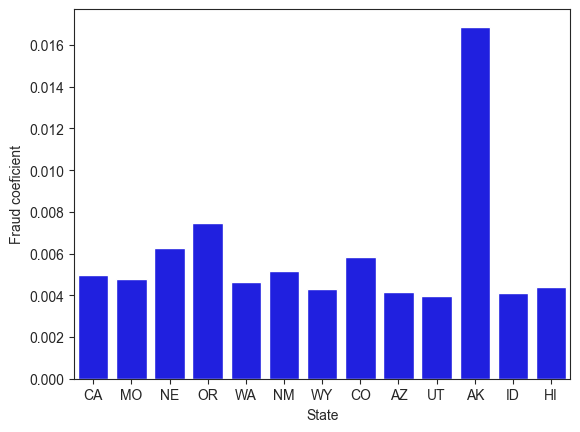

,is_fraud,trans_num,coef
state,,,
CA,402,80495,0.004994
MO,262,54904,0.004772
NE,216,34425,0.006275
OR,197,26408,0.007460
WA,126,27040,0.004660
NM,121,23427,0.005165
WY,119,27776,0.004284
CO,115,19766,0.005818
AZ,64,15362,0.004166


In [10]:
fraud_state = ccf_fraud.groupby('state')['is_fraud'].count().sort_values(ascending=False)
fraud_state_trans = ccf.groupby('state')['trans_num'].count().sort_values(ascending=False)
fraud_merged=pd.merge(fraud_state,fraud_state_trans,on='state',how='inner')
fraud_merged['coef'] = fraud_merged['is_fraud']/fraud_merged['trans_num']
sns.barplot(x='state',y='coef',data=fraud_merged,color='b')
plt.xlabel('State')
plt.ylabel('Fraud coeficient')
plt.show()
fraud_merged

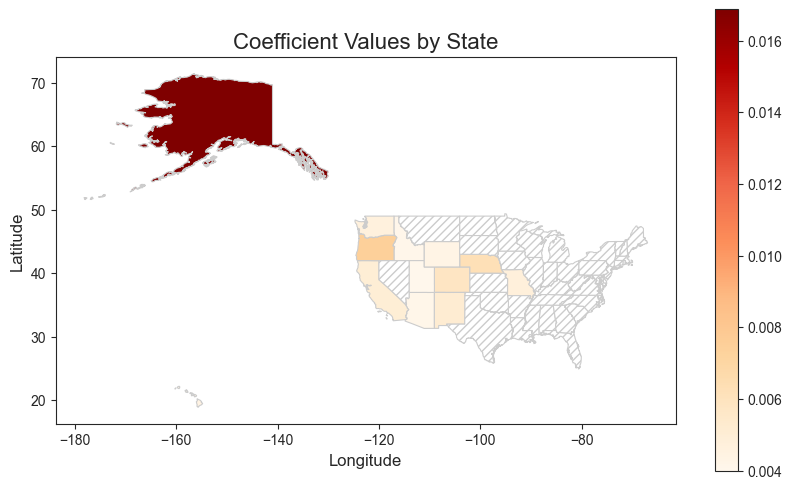

In [11]:
#Visualize in a map where there is more fraud in relation to the total.
fraud_merged['State_Code'] = fraud_merged.index
import geopandas as gpd

# Replace 'your_geojson_file.geojson' with the path to your GeoJSON file
geojson_file = 'States_shapefile.geojson'

# Read GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_file)

# Display the GeoDataFrame
merged_df = gdf.merge(fraud_merged, on='State_Code',how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_df.plot(column='coef', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
               missing_kwds={'color': 'white', 'edgecolor': '0.8', 'hatch': '////'})
# Add title and labels
plt.title('Coefficient Values by State', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Show the map
plt.show()

It is shown that primarily on alaska there is a higher rate of credit card fraud

Now we implemented a random forest classifier with adjustments to classifications. 

In [12]:
X = ccf[['trans_date_trans_time', 'category', 'amt', 'city', 'state', 'city_pop', 'job', 'dob','merchant']]
y = ccf['is_fraud']

# Encode categorical features
label_encoder = LabelEncoder()
for col in ['merchant', 'category', 'city', 'state', 'job', 'dob']:
    X[col] = label_encoder.fit_transform(X[col])

# Convert 'dob' to age
X['dob'] = (pd.to_datetime('now') - pd.to_datetime(X['dob'])).astype('<m8[Y]')

# Extract features from datetime
X['hour_of_day'] = X['trans_date_trans_time'].dt.hour
X['day_of_week'] = X['trans_date_trans_time'].dt.dayofweek

# Drop original datetime column and other unnecessary columns
X = X.drop(['trans_date_trans_time', 'dob'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set with probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Adjust threshold for classification
threshold = 0.3
y_pred_adjusted = (y_pred_prob > threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
#mejor modelo hasta ahora (balance entre precision y recall)

Accuracy: 1.00
Precision: 0.81
Recall: 0.75
F1 Score: 0.78
Confusion Matrix:
[[67490    65]
 [   90   277]]


The model's performance in terms of recall aligns well with the specified requirements, and after evaluating various models, SMOBE exhibited a higher recall rate. However, it should be noted that this came at the cost of a slightly lower precision of 0.34. Despite considering alternative models, those achieving commendable recall values showed suboptimal precision, hovering around 0.1 in F1 score. Consequently, after thorough evaluation, the decision was made to retain the current model as it strikes a balance between recall and precision, meeting the specified criteria effectively.

[Source](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv)

# Summary and conclusions

Summary of Insights:
1. The 5 most fraudulent transactions are: grocery, shopping online, miscelaneous online, shopping, gas.
2. Most frauds occur during night and evening.
3. The distribution of victims` age is right skewed, with peaks in the 30-40 and 50-60 age range.
4. Most fraudulent purchases do not involve large amounts of money.
5. Alaska has the highest ratio of fraudulent activity.

A random forest with modifications was implemented, with:

Accuracy: 1.00,
Precision: 0.81,
Recall: 0.75,
F1 Score: 0.78.

Indicating an acceptable behaviour towards achieving the goal.
Further refinement and optimization may be pursued based on these insights to enhance the model's efficacy in meeting the desired goals.
- The dataset used for the analysis was sourced from [Kaggle](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv).